# JPMC Take Home - Census Income Classification & Marketing Segmentation

**Goal 1 (Classification):** Predict whether a person earns **> 50K** USD vs **≤ $50K** using ~40 demographic/employment variables.  
**Goal 2 (Segmentation):** Create a customer segmentation model and describe how segments differ and how marketing can use them.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports & Paths

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/MyDrive/census-bureau.data"
COLS_PATH = "/content/drive/MyDrive/census-bureau.columns"

## Read Column Names for Data

In [3]:
col_names = []
with open(COLS_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        m = re.match(r"^\s*\d+\s*[:\t, ]\s*(.+?)\s*$", line)
        name = m.group(1) if m else line
        name = re.sub(r"\s+", "_", name)
        name = re.sub(r"[^\w_]", "", name)
        col_names.append(name)

print(f"Loaded {len(col_names)} column names")
col_names[:10], col_names[-5:]

Loaded 42 column names


(['age',
  'class_of_worker',
  'detailed_industry_recode',
  'detailed_occupation_recode',
  'education',
  'wage_per_hour',
  'enroll_in_edu_inst_last_wk',
  'marital_stat',
  'major_industry_code',
  'major_occupation_code'],
 ['fill_inc_questionnaire_for_veterans_admin',
  'veterans_benefits',
  'weeks_worked_in_year',
  'year',
  'label'])

## Load Raw Data

In [4]:
df_raw = pd.read_csv(
    DATA_PATH,
    header=None,
    sep=",",
    skipinitialspace=True,
    na_values=["?", " ?"],
    engine="python"
)

print("Raw shape:", df_raw.shape)

if len(col_names) != df_raw.shape[1]:
    raise ValueError(f"Column mismatch: data has {df_raw.shape[1]} cols, columns file has {len(col_names)}")

df_raw.columns = col_names
df_raw.head()

Raw shape: (199523, 42)


,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


# EDA

## First Look EDA

In [5]:
df = df_raw.copy()

print("Shape:", df.shape)
display(df.head(3))

# Data types + non-null counts
display(df.info())

# Sample a few rows to see categorical formatting
display(df.sample(5, random_state=42))

Shape: (199523, 42)


,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   age                                        199523 non-null  int64  
 1   class_of_worker                            199523 non-null  object 
 2   detailed_industry_recode                   199523 non-null  int64  
 3   detailed_occupation_recode                 199523 non-null  int64  
 4   education                                  199523 non-null  object 
 5   wage_per_hour                              199523 non-null  int64  
 6   enroll_in_edu_inst_last_wk                 199523 non-null  object 
 7   marital_stat                               199523 non-null  object 
 8   major_industry_code                        199523 non-null  object 
 9   major_occupation_code                      199523 non-null  object 
 10  race    

None

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,label
57440,47,Local government,43,26,High school graduate,0,Not in universe,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,22,94,- 50000.
70971,39,Private,25,26,High school graduate,0,Not in universe,Divorced,Manufacturing-nondurable goods,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
57415,56,Private,41,8,Associates degree-occup /vocational,600,Not in universe,Married-civilian spouse present,Hospital services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
159416,39,Federal government,50,6,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Public administration,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
97793,11,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


## Duplicate Check and Removal

In [6]:
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

df = df.drop_duplicates().reset_index(drop=True)
print("After dedup:", df.shape)

Duplicate rows: 3229
After dedup: (196294, 42)


## Data Quality Checks
I checked for duplicated rows (common in merged extracts) and removed exact duplicates to prevent inflated performance estimates.


## Clean Strings + Convert “Not in universe…” to Missing

In [7]:
obj_cols = df.select_dtypes(include="object").columns

df[obj_cols] = df[obj_cols].apply(lambda s: s.astype("string").str.strip())

def not_in_universe_to_na(x):
    if x is pd.NA or x is None:
        return pd.NA
    if isinstance(x, str) and x.lower().startswith("not in universe"):
        return pd.NA
    return x

for c in obj_cols:
    df[c] = df[c].map(not_in_universe_to_na)

df[obj_cols].head()

,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,...,migration_codemove_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,fill_inc_questionnaire_for_veterans_admin,label
0,<NA>,High school graduate,<NA>,Widowed,<NA>,<NA>,White,All other,Female,<NA>,...,<NA>,<NA>,<NA>,<NA>,United-States,United-States,United-States,Native- Born in the United States,<NA>,- 50000.
1,Self-employed-not incorporated,Some college but no degree,<NA>,Divorced,Construction,Precision production craft & repair,White,All other,Male,<NA>,...,Same county,No,Yes,<NA>,United-States,United-States,United-States,Native- Born in the United States,<NA>,- 50000.
2,<NA>,10th grade,High school,Never married,<NA>,<NA>,Asian or Pacific Islander,All other,Female,<NA>,...,<NA>,<NA>,<NA>,<NA>,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,<NA>,- 50000.
3,<NA>,Children,<NA>,Never married,<NA>,<NA>,White,All other,Female,<NA>,...,Nonmover,Yes,<NA>,Both parents present,United-States,United-States,United-States,Native- Born in the United States,<NA>,- 50000.
4,<NA>,Children,<NA>,Never married,<NA>,<NA>,White,All other,Female,<NA>,...,Nonmover,Yes,<NA>,Both parents present,United-States,United-States,United-States,Native- Born in the United States,<NA>,- 50000.


## Missingness Report

In [8]:
missing = df.isna().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({"missing_rate": missing, "missing_count": df.isna().sum()})
display(missing_df.head(20))

# Optional: columns with any missingness
cols_with_missing = missing[missing > 0].index.tolist()
print(f"Columns with missing: {len(cols_with_missing)}")
cols_with_missing[:20]

,missing_rate,missing_count
age,0.000000,0
capital_gains,0.000000,0
capital_losses,0.000000,0
citizenship,0.000000,0
class_of_worker,0.494304,97029
country_of_birth_father,0.034148,6703
country_of_birth_mother,0.031111,6107
country_of_birth_self,0.017265,3389
detailed_household_and_family_stat,0.000000,0
detailed_household_summary_in_household,0.000000,0


Columns with missing: 19


['fill_inc_questionnaire_for_veterans_admin',
 'reason_for_unemployment',
 'enroll_in_edu_inst_last_wk',
 'state_of_previous_residence',
 'region_of_previous_residence',
 'migration_prev_res_in_sunbelt',
 'member_of_a_labor_union',
 'family_members_under_18',
 'migration_codechange_in_msa',
 'migration_codemove_within_reg',
 'migration_codechange_in_reg',
 'live_in_this_house_1_year_ago',
 'major_industry_code',
 'major_occupation_code',
 'class_of_worker',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth_self',
 'hispanic_origin']

## Target Label Cleanup and Binary Target

In [9]:
income_col = "income" if "income" in df.columns else df.columns[-1]

df[income_col] = (
    df[income_col]
    .astype("string")
    .str.replace(".", "", regex=False)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

df["income_binary"] = df[income_col].map({"- 50000": 0, "50000+": 1})

print("Target value_counts (raw):")
display(df[income_col].value_counts(dropna=False))

# Drop rows without valid target
before = len(df)
df = df[df["income_binary"].notna()].reset_index(drop=True)
after = len(df)
print(f"Dropped {before-after} rows with invalid/missing target")

Target value_counts (raw):


,count
label,
- 50000,183912
50000+,12382


Dropped 0 rows with invalid/missing target


## Weight Column Handling + Sanity Checks

In [10]:
if "weight" not in df.columns:
    raise ValueError("Expected 'weight' column not found. Check columns file.")

df["weight"] = pd.to_numeric(df["weight"], errors="coerce").fillna(1.0)

print("Weight summary:")
display(df["weight"].describe())

print("Any non-positive weights?", (df["weight"] <= 0).any())

Weight summary:


,weight
count,196294.000000
mean,1743.267584
std,996.945985
min,37.870000
25%,1061.530000
50%,1620.175000
75%,2194.060000
max,18656.300000


Any non-positive weights? False


## Survey Weights
The dataset includes a `weight` column indicating how much of the population each record represents due to stratified sampling. We retain weights for (1) weighted evaluation and (2) training with sample_weight where supported.


## Numeric Conversion + Type Summary

In [11]:
# Convert numeric-ish string columns conservatively
for c in df.columns:
    if c in [income_col, "income_binary"]:
        continue
    if df[c].dtype == "string":
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().mean() >= 0.95:
            df[c] = coerced

# sklearn compatibility
df = df.replace({pd.NA: np.nan})

print("Dtypes summary:")
display(df.dtypes.value_counts())

Dtypes summary:


,count
object,28
int64,13
float64,1
string[python],1


## Target Balance (Unweighted + Weighted)

In [12]:
# Unweighted class balance
unweighted = df["income_binary"].value_counts(normalize=True).sort_index()
print("Unweighted class balance (0=<=50K, 1=>50K):")
display(unweighted)

# Weighted class balance
weighted_pos = df.loc[df["income_binary"] == 1, "weight"].sum()
weighted_total = df["weight"].sum()
print("Weighted positive rate:", weighted_pos / weighted_total)

Unweighted class balance (0=<=50K, 1=>50K):


,proportion
income_binary,
0,0.936921
1,0.063079


Weighted positive rate: 0.06499620794442151


## Summary Stats for Numeric Columns

In [13]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["income_binary"]]  # keep weight in

display(df[num_cols].describe().T.sort_values("std", ascending=False).head(20))

,count,mean,std,min,25%,50%,75%,max
capital_gains,196294.0,441.870037,4735.677027,0.00,0.00,0.000,0.00,99999.0
dividends_from_stocks,196294.0,200.722386,2000.130616,0.00,0.00,0.000,0.00,99999.0
weight,196294.0,1743.267584,996.945985,37.87,1061.53,1620.175,2194.06,18656.3
wage_per_hour,196294.0,56.336505,277.054333,0.00,0.00,0.000,0.00,9999.0
capital_losses,196294.0,37.927593,274.081174,0.00,0.00,0.000,0.00,4608.0
weeks_worked_in_year,196294.0,23.553889,24.428588,0.00,0.00,12.000,52.00,52.0
age,196294.0,34.929468,22.210001,0.00,16.00,34.000,50.00,90.0
detailed_industry_recode,196294.0,15.603187,18.106401,0.00,0.00,1.000,33.00,51.0
detailed_occupation_recode,196294.0,11.490468,14.498128,0.00,0.00,2.000,26.00,46.0
num_persons_worked_for_employer,196294.0,1.988105,2.371018,0.00,0.00,1.000,4.00,6.0


## Categorical Cardinality + Top Value Counts

In [14]:
cat_cols = df.select_dtypes(include=["object", "string"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [income_col]]

cardinality = pd.Series({c: df[c].nunique(dropna=True) for c in cat_cols}).sort_values(ascending=False)
display(cardinality.head(20))

# show top categories for a few high-impact columns
for c in cardinality.head(8).index:
    print(f"\n=== {c} (top 10) ===")
    display(df[c].value_counts(dropna=False).head(10))

,0
state_of_previous_residence,49
country_of_birth_father,42
country_of_birth_self,42
country_of_birth_mother,42
detailed_household_and_family_stat,38
major_industry_code,23
education,17
major_occupation_code,14
hispanic_origin,9
class_of_worker,8



=== state_of_previous_residence (top 10) ===


,count
state_of_previous_residence,
NaN,181269
California,1710
Utah,1061
Florida,847
North Carolina,810
Abroad,671
Oklahoma,622
Minnesota,572
Indiana,528



=== country_of_birth_father (top 10) ===


,count
country_of_birth_father,
United-States,156037
Mexico,9948
NaN,6703
Puerto-Rico,2676
Italy,2212
Canada,1380
Germany,1356
Dominican-Republic,1284
Poland,1210



=== country_of_birth_self (top 10) ===


,count
country_of_birth_self,
United-States,173783
Mexico,5759
NaN,3389
Puerto-Rico,1400
Germany,850
Philippines,844
Cuba,836
Canada,700
El-Salvador,689



=== country_of_birth_mother (top 10) ===


,count
country_of_birth_mother,
United-States,157355
Mexico,9721
NaN,6107
Puerto-Rico,2468
Italy,1844
Canada,1451
Germany,1382
Philippines,1228
Poland,1109



=== detailed_household_and_family_stat (top 10) ===


,count
detailed_household_and_family_stat,
Householder,53242
Child <18 never marr not in subfamily,47219
Spouse of householder,41670
Nonfamily householder,22205
Child 18+ never marr Not in a subfamily,12016
Secondary individual,6109
Other Rel 18+ ever marr not in subfamily,1953
Grandchild <18 never marr child of subfamily RP,1839
Other Rel 18+ never marr not in subfamily,1726



=== major_industry_code (top 10) ===


,count
major_industry_code,
NaN,97467
Retail trade,17069
Manufacturing-durable goods,9014
Education,8283
Manufacturing-nondurable goods,6895
Finance insurance and real estate,6145
Construction,5984
Business and repair services,5651
Medical except hospital,4683



=== education (top 10) ===


,count
education,
High school graduate,48374
Children,44347
Some college but no degree,27809
Bachelors degree(BA AB BS),19859
7th and 8th grade,7976
10th grade,7539
11th grade,6862
Masters degree(MA MS MEng MEd MSW MBA),6540
9th grade,6193



=== major_occupation_code (top 10) ===


,count
major_occupation_code,
NaN,97467
Adm support including clerical,14836
Professional specialty,13940
Executive admin and managerial,12495
Other service,12097
Sales,11781
Precision production craft & repair,10517
Machine operators assmblrs & inspctrs,6377
Handlers equip cleaners etc,4126


##  Relationship of Features to Income (Fast “Signal Check”)

In [15]:
numeric_check_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ["income_binary", "weight"]]
group_means = df.groupby("income_binary")[numeric_check_cols].mean(numeric_only=True).T
display(group_means.head(25))

income_binary,0,1
age,34.166215,46.266193
detailed_industry_recode,14.692320,29.132450
detailed_occupation_recode,11.452102,12.060330
wage_per_hour,54.632911,81.640284
capital_gains,146.373597,4830.930060
capital_losses,27.477843,193.139557
dividends_from_stocks,109.649213,1553.448070
num_persons_worked_for_employer,1.852402,4.003715
own_business_or_self_employed,0.172631,0.262559
veterans_benefits,1.508346,1.981344


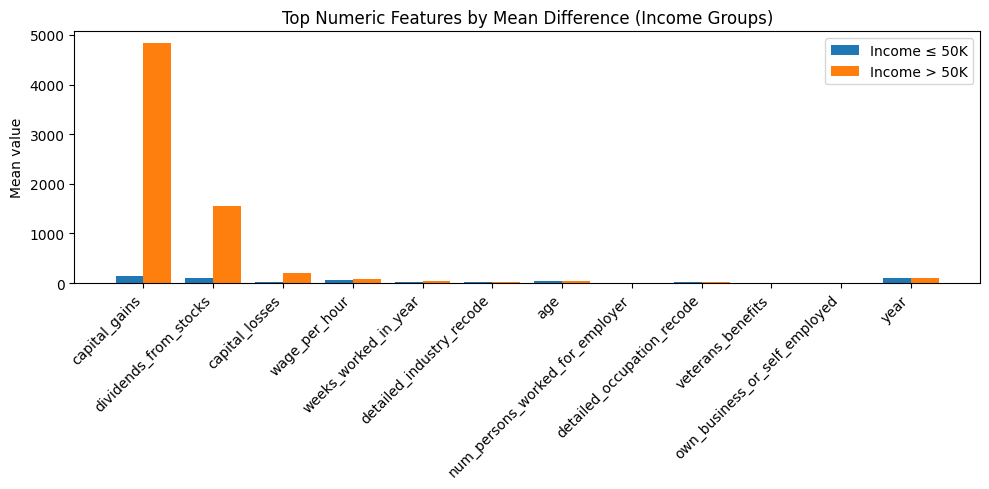

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Compute absolute mean difference
group_means["abs_diff"] = (group_means[1] - group_means[0]).abs()

# Select top features by absolute difference
top_n = 12
top_feats = group_means.sort_values("abs_diff", ascending=False).head(top_n)

# Plot
x = np.arange(len(top_feats))

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, top_feats[0], width=0.4, label="Income ≤ 50K")
plt.bar(x + 0.2, top_feats[1], width=0.4, label="Income > 50K")

plt.xticks(x, top_feats.index, rotation=45, ha="right")
plt.ylabel("Mean value")
plt.title("Top Numeric Features by Mean Difference (Income Groups)")
plt.legend()
plt.tight_layout()
plt.show()

## Categorical vs Label (Top lift)

In [17]:
def top_category_lift(col, top_k=8):
    tmp = (
        df[[col, "income_binary", "weight"]]
        .dropna(subset=[col])
        .groupby(col)
        .apply(lambda g: pd.Series({
            "count": len(g),
            "weighted_rate": (g["income_binary"] * g["weight"]).sum() / g["weight"].sum()
        }))
        .reset_index()
        .sort_values("count", ascending=False)
    )
    return tmp.head(top_k)

for c in ["education", "class_of_worker", "marital_stat"]:
    if c in df.columns:
        print(f"\n=== {c} ===")
        display(top_category_lift(c, top_k=10))


=== education ===


/tmp/ipython-input-2832972081.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,education,count,weighted_rate
12,High school graduate,48374.0,0.037647
10,Children,44347.0,0.000000
16,Some college but no degree,27809.0,0.064985
9,Bachelors degree(BA AB BS),19859.0,0.203527
5,7th and 8th grade,7976.0,0.008870
0,10th grade,7539.0,0.008365
1,11th grade,6862.0,0.010331
14,Masters degree(MA MS MEng MEd MSW MBA),6540.0,0.315963
6,9th grade,6193.0,0.005989
8,Associates degree-occup /vocational,5358.0,0.075936



=== class_of_worker ===


/tmp/ipython-input-2832972081.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,class_of_worker,count,weighted_rate
3,Private,72021.0,0.102241
5,Self-employed-not incorporated,8442.0,0.132971
1,Local government,7783.0,0.112201
6,State government,4227.0,0.117224
4,Self-employed-incorporated,3264.0,0.362913
0,Federal government,2925.0,0.210753
2,Never worked,438.0,0.002945
7,Without pay,165.0,0.001849



=== marital_stat ===


/tmp/ipython-input-2832972081.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,marital_stat,count,weighted_rate
2,Married-civilian spouse present,84194.0,0.119391
4,Never married,83296.0,0.014124
0,Divorced,12707.0,0.080689
6,Widowed,10456.0,0.031992
5,Separated,3459.0,0.050382
3,Married-spouse absent,1517.0,0.055987
1,Married-A F spouse present,665.0,0.024952


/tmp/ipython-input-1460996793.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


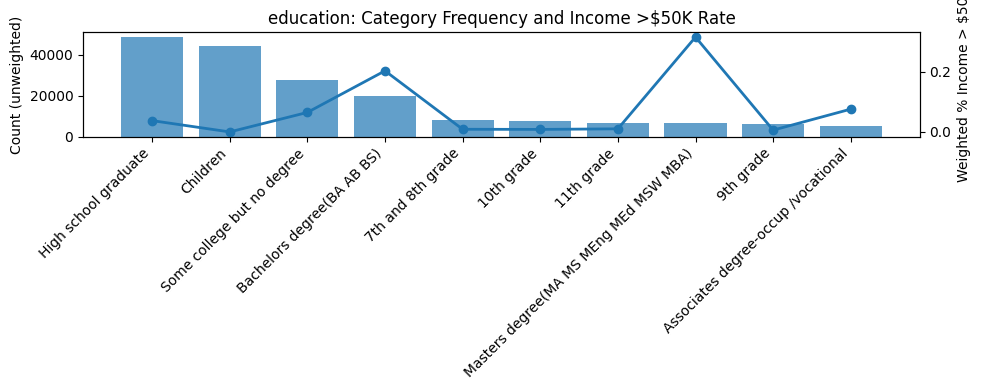

/tmp/ipython-input-1460996793.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


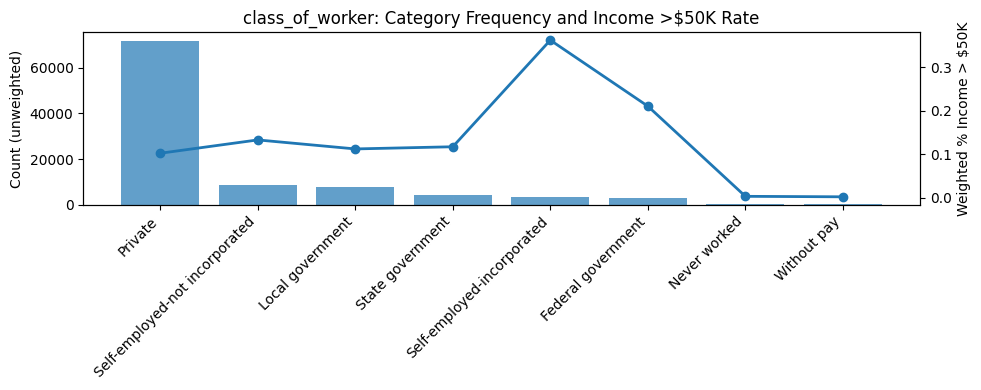

/tmp/ipython-input-1460996793.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


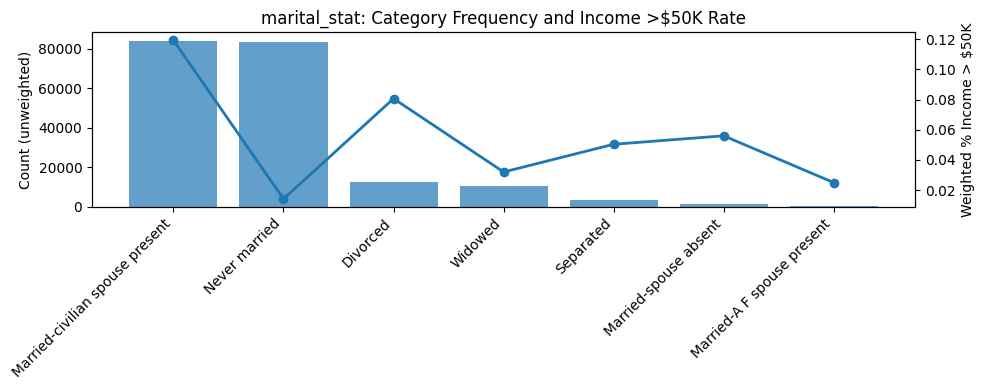

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_category_lifts(df, cols, top_k=10):
    """
    For each categorical column:
    - bars: unweighted count
    - line: weighted % income >50K
    """
    for col in cols:
        if col not in df.columns:
            continue

        tmp = (
            df[[col, "income_binary", "weight"]]
            .dropna(subset=[col])
            .groupby(col)
            .apply(lambda g: pd.Series({
                "count": len(g),
                "weighted_rate": (g["income_binary"] * g["weight"]).sum() / g["weight"].sum()
            }))
            .reset_index()
            .sort_values("count", ascending=False)
            .head(top_k)
        )

        x = np.arange(len(tmp))

        fig, ax1 = plt.subplots(figsize=(10, 4))

        # Bar: frequency
        ax1.bar(x, tmp["count"], alpha=0.7)
        ax1.set_ylabel("Count (unweighted)")
        ax1.set_xticks(x)
        ax1.set_xticklabels(tmp[col], rotation=45, ha="right")

        # Line: weighted income rate
        ax2 = ax1.twinx()
        ax2.plot(x, tmp["weighted_rate"], marker="o", linewidth=2)
        ax2.set_ylabel("Weighted % Income > $50K")

        plt.title(f"{col}: Category Frequency and Income >$50K Rate")
        plt.tight_layout()
        plt.show()


# ---- Run plots ----
plot_top_category_lifts(
    df,
    cols=["education", "class_of_worker", "marital_stat"],
    top_k=10
)


## Exploratory Data Analysis (EDA)

### What I did

1. **Validated the target and survey design**
   - Confirmed the binary target `income_binary` (0 = ≤$50K, 1 = >$50K).
   - Computed both **unweighted** and **survey-weighted** base rates to ensure conclusions reflect the underlying population and not just the sample.

2. **Quantified numeric separation between income groups**
   - For all numeric columns (excluding `income_binary` and `weight`), I computed group means by income class:
     - `group_means = df.groupby("income_binary")[numeric_cols].mean().T`
   - Plotted the **top numeric features by mean difference** between the two income groups to identify the strongest continuous signals.

3. **Estimated categorical “lift” for key categorical variables**
   - For `education`, `class_of_worker`, and `marital_stat`, I computed:
     - each category’s frequency (count)
     - the **weighted income >$50K rate** within that category
   - Plotted a combined chart for each variable:
     - **bars** = category frequency (unweighted)
     - **line** = weighted % income >$50K (category-level uplift)

4. **Used EDA to guide preprocessing/modeling choices**
   - Identified heavy skew / zero-inflation in capital variables, motivating `log1p` transformations.
   - Observed high-cardinality and structural categories, motivating careful encoding and handling of “not applicable” values.
   - Confirmed severe class imbalance, motivating PR-AUC, weighting, and threshold tuning (rather than accuracy).

---

### Summary of findings (from the EDA outputs)

- **Severe class imbalance:** Only **~6.3%** of observations are `>50K` (unweighted 0.0631; weighted ~0.0650). This is a core modeling constraint, so accuracy will be misleading.
- **Weights won’t change the story much:** Weighted positive rate is only slightly higher than unweighted (6.50% vs 6.31%), so the imbalance is real and not a sampling artifact.
- **Numeric features are heavily zero-inflated and right-skewed:**
  - `capital_gains`, `dividends_from_stocks`, `wage_per_hour`, and `capital_losses` show extreme skew and top-coding/outliers (large maximum values). This suggests non-linear effects and motivates `log1p` transforms for robustness.
- **Work participation is highly discriminative:**
  - `weeks_worked_in_year` is substantially higher for `>50K` than `<=50K`, indicating labor attachment is a major driver.
  - Related work-intensity measures (e.g., number of persons worked for employer) also show strong separation.
- **Demographic and “human capital” signals align with intuition and domain expectations:**
  - `age` is higher for `>50K`.
  - **Education has a monotonic uplift**: higher education levels correspond to higher weighted >$50K rates, while “Children” is near zero.
  - **Class of worker** shows strong differences: self-employed incorporated and federal government categories show notably higher uplift than private-sector baseline.
  - **Marital status**: married-civilian spouse present has a much higher rate than never married, consistent with dual-income household effects.
- **Structural missingness appears in mobility features:**
  - Fields like prior residence are frequently missing because they are often “not applicable unless moved,” implying missingness is structural rather than random.
- **Several high-cardinality categorical fields exist:**
  - Geography and birthplace fields have many levels, which motivates controlled encoding (frequency thresholds, grouping rare categories, or regularized models).

---

### What this implies (modeling implications)

1. **Accuracy should not be the headline metric.** With ~94% in class 0, a naïve classifier can achieve ~94% accuracy with no business value. PR-AUC, ROC-AUC, recall/precision tradeoffs, and calibrated thresholds are more informative.
2. **Income signal is strongly tied to labor attachment and human capital.** Features like weeks worked, education, occupation/industry, and worker class drive the largest separations, indicating the dataset is coherent and predictive.
3. **Non-linear models should outperform linear ones.** The combination of skewed numeric variables, zero-inflation, and interactions (e.g., education × occupation × weeks worked) suggests tree-based models (Random Forest, XGBoost, LightGBM) will capture structure better than a pure linear baseline.


# Data Preperation (Pre-Modelling - Based on EDA)

## Drop ultra-sparse columns

Two variables exhibit extreme sparsity (>90% “Not in universe” / missing):
- `fill_inc_questionnaire_for_veterans_admin`
- `enroll_in_edu_inst_last_wk`

These fields are conditionally defined for very small subpopulations and provide
limited signal at the population level.

**Decision:**  
They are retained in the raw dataset for transparency but excluded from  modeling to avoid noise and unstable estimates.

In [19]:
# Drop ultra-sparse columns (excluded due to extreme sparsity)
drop_sparse_cols = [
    "fill_inc_questionnaire_for_veterans_admin",
    "enroll_in_edu_inst_last_wk"
]

df = df.drop(columns=[c for c in drop_sparse_cols if c in df.columns], errors="ignore")

print("Dropped sparse columns.")
print("df shape:", df.shape)

Dropped sparse columns.
df shape: (196294, 41)


## Handle NA's

In [20]:
target_col = "income_binary"
weight_col = "weight"

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in [target_col, weight_col]]

cat_cols = [c for c in df.columns if c not in num_cols + [target_col, weight_col]]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

# Numeric: median (robust to skew & outliers)
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# Categorical: explicit placeholder
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna("Unknown")

print("Remaining missing values:", df.isna().sum().sum())

Numeric columns: 12
Categorical columns: 27
Remaining missing values: 0


## Skew handling via log

In [21]:
log_cols = [
    "capital_gains",
    "dividends_from_stocks",
    "capital_losses"
]

optional_log_cols = ["wage_per_hour"]  # optional but useful

for c in log_cols:
    if c in df.columns:
        df[f"{c}__log1p"] = np.log1p(df[c])

for c in optional_log_cols:
    if c in df.columns:
        df[f"{c}__log1p"] = np.log1p(df[c])

print("Log-transformed columns added:")
[c for c in df.columns if c.endswith("__log1p")]

Log-transformed columns added:


['capital_gains__log1p',
 'dividends_from_stocks__log1p',
 'capital_losses__log1p',
 'wage_per_hour__log1p']

I created log1p-transformed versions of highly skewed monetary variables to stabilize linear baselines. For tree-based models we retained both raw and log features; for linear models we optionally use only the log-transformed versions to reduce redundancy and improve coefficient stability.

In [22]:
# Final modeling matrices (train-test split comes later)
y = df[target_col].astype(int).values
w = df[weight_col].values

X = df.drop(columns=[target_col, weight_col])

print("Final shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("w:", w.shape)

Final shapes:
X: (196294, 43)
y: (196294,)
w: (196294,)


# Modelling

## Train-test Split

In [23]:
# Remove raw label column to prevent target leakage
df = df.drop(columns=["label"], errors="ignore")

print("Removed raw label column (if present).")
print("Remaining columns:", df.shape[1])

Removed raw label column (if present).
Remaining columns: 44


In [24]:
from sklearn.model_selection import train_test_split

target_col = "income_binary"
weight_col = "weight"

# Safety: ensure these exist
assert target_col in df.columns and weight_col in df.columns

X_df = df.drop(columns=[target_col, weight_col])
y = df[target_col].astype(int).values
w = df[weight_col].values

X_train_df, X_test_df, y_train, y_test, w_train, w_test = train_test_split(
    X_df, y, w,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train_df.shape, "Test shape:", X_test_df.shape)
print("Train positive rate:", y_train.mean(), "Test positive rate:", y_test.mean())

Train shape: (157035, 42) Test shape: (39259, 42)
Train positive rate: 0.06308147865125609 Test positive rate: 0.06306834101734635


## Preprocessing: encoding + scaling

In [25]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Identify columns on TRAIN only (best practice)
num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train_df.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # scaling helps LR; harmless for others
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

Numeric cols: 16 | Categorical cols: 26


## Metrics + Eval Functions

In [26]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support,
    confusion_matrix
)

def evaluate_probs(y_true, y_prob, sample_weight=None, threshold=0.5, label="model"):
    y_pred = (y_prob >= threshold).astype(int)

    roc = roc_auc_score(y_true, y_prob, sample_weight=sample_weight)
    pr  = average_precision_score(y_true, y_prob, sample_weight=sample_weight)

    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", sample_weight=sample_weight, zero_division=0
    )

    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)

    print(f"\n=== {label} @ threshold={threshold:.2f} ===")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    print(f"Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f}")
    print("Weighted Confusion Matrix [[TN, FP],[FN, TP]]:\n", cm)

def best_threshold_by_f1(y_true, y_prob, sample_weight=None):
    thresholds = np.linspace(0.05, 0.95, 19)
    best = (0.5, -1)
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        _, _, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", sample_weight=sample_weight, zero_division=0
        )
        if f1 > best[1]:
            best = (t, f1)
    return best


## SHAP Function

In [27]:
def get_feature_names_from_ct(ct):
    """
    Extract feature names from a fitted ColumnTransformer
    with numeric + one-hot encoded categorical pipelines.
    """
    feature_names = []

    for name, transformer, cols in ct.transformers_:
        if name == "remainder" and transformer == "drop":
            continue

        if name == "num":
            feature_names.extend(cols)

        elif name == "cat":
            ohe = transformer.named_steps["onehot"]
            ohe_names = ohe.get_feature_names_out(cols)
            feature_names.extend(ohe_names)

    return np.array(feature_names)


In [28]:
import shap
def get_transformed_X_and_feature_names(pipe, X_df):
    """
    Transforms X_df using a fitted sklearn Pipeline (with ColumnTransformer),
    returns:
      - dense numeric matrix (float32)
      - corresponding feature names
    """
    ct = pipe.named_steps["preprocess"]

    # Transform
    X_trans = ct.transform(X_df)

    # Sparse → dense
    if hasattr(X_trans, "toarray"):
        X_trans = X_trans.toarray()

    # FORCE numeric dtype (CRITICAL FOR SHAP)
    X_trans = X_trans.astype(np.float32)

    # Get feature names
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if name == "remainder" and transformer == "drop":
            continue

        if name == "num":
            feature_names.extend(cols)

        elif name == "cat":
            ohe = transformer.named_steps["onehot"]
            feature_names.extend(ohe.get_feature_names_out(cols))

    return X_trans, np.array(feature_names)


## Model 1 — Logistic Regression (weighted, scaled)

In [ ]:
from sklearn.linear_model import LogisticRegression

# OPTIONAL: for linear stability, drop raw skewed columns if log versions exist
DROP_RAW_SKEW_FOR_LR = True
raw_skew = ["capital_gains", "dividends_from_stocks", "capital_losses", "wage_per_hour"]

if DROP_RAW_SKEW_FOR_LR:
    drop_cols = [c for c in raw_skew if c in X_train_df.columns and f"{c}__log1p" in X_train_df.columns]
    X_train_lr = X_train_df.drop(columns=drop_cols, errors="ignore")
    X_test_lr  = X_test_df.drop(columns=drop_cols, errors="ignore")
else:
    X_train_lr, X_test_lr = X_train_df, X_test_df

# Rebuild preprocess because columns changed
num_cols_lr = X_train_lr.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_lr = [c for c in X_train_lr.columns if c not in num_cols_lr]

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), num_cols_lr),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols_lr)
    ],
    remainder="drop"
)

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",   # handles imbalance (still use sample_weight too)
    n_jobs=None
)

lr_pipe = Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("model", lr)
])

lr_pipe.fit(X_train_lr, y_train, model__sample_weight=w_train)

lr_prob = lr_pipe.predict_proba(X_test_lr)[:, 1]
t_lr, f1_lr = best_threshold_by_f1(y_test, lr_prob, sample_weight=w_test)
evaluate_probs(y_test, lr_prob, sample_weight=w_test, threshold=t_lr, label="LogReg (weighted)")


=== LogReg (weighted) @ threshold=0.85 ===
ROC-AUC: 0.9414 | PR-AUC: 0.5989
Precision: 0.5320 | Recall: 0.6062 | F1: 0.5667
Weighted Confusion Matrix [[TN, FP],[FN, TP]]:
 [[61371685.96999973  2400572.94      ]
 [ 1772320.62        2728696.88      ]]


## Hyperparameter Tunning (LogReg)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_lr = {
    "model__C": np.logspace(-3, 2, 12),
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

search_lr = RandomizedSearchCV(
    lr_pipe,
    param_distributions=param_dist_lr,
    n_iter=12,
    scoring="average_precision",   # PR-AUC is best for imbalance
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_lr.fit(X_train_lr, y_train, model__sample_weight=w_train)

best_lr = search_lr.best_estimator_
print("Best LR params:", search_lr.best_params_)

lr_prob = best_lr.predict_proba(X_test_lr)[:, 1]
t_lr, _ = best_threshold_by_f1(y_test, lr_prob, sample_weight=w_test)
evaluate_probs(y_test, lr_prob, sample_weight=w_test, threshold=t_lr, label="LogReg Tuned (weighted)")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best LR params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': np.float64(0.001)}

=== LogReg Tuned (weighted) @ threshold=0.85 ===
ROC-AUC: 0.9415 | PR-AUC: 0.5989
Precision: 0.5314 | Recall: 0.6052 | F1: 0.5659
Weighted Confusion Matrix [[TN, FP],[FN, TP]]:
 [[61370139.67999972  2402119.23      ]
 [ 1776854.65        2724162.85      ]]


In [ ]:
def get_feature_names_from_ct(ct: ColumnTransformer):
    # Works for this standard (num + onehot) setup
    feature_names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if name == "num":
            feature_names.extend(cols)
        elif name == "cat":
            ohe = trans.named_steps["onehot"]
            ohe_names = list(ohe.get_feature_names_out(cols))
            feature_names.extend(ohe_names)
    return np.array(feature_names)

ct = best_lr.named_steps["preprocess"]
feat_names = get_feature_names_from_ct(ct)

coefs = best_lr.named_steps["model"].coef_.ravel()
imp = pd.DataFrame({"feature": feat_names, "coef": coefs, "abs_coef": np.abs(coefs)}).sort_values("abs_coef", ascending=False)

display(imp.head(25))

,feature,coef,abs_coef
383,country_of_birth_self_Scotland,2.833735,2.833735
32,education_Doctorate degree(PhD EdD),2.515296,2.515296
31,education_Children,-2.285418,2.285418
36,education_Prof school degree (MD DDS DVM LLB JD),2.232410,2.232410
158,state_of_previous_residence_Nevada,2.023571,2.023571
71,major_occupation_code_Executive admin and managerial,-1.992210,1.992210
34,education_Less than 1st grade,-1.861312,1.861312
297,country_of_birth_father_Scotland,-1.740209,1.740209
2,detailed_occupation_recode,-1.709394,1.709394
20,class_of_worker_Without pay,-1.651442,1.651442


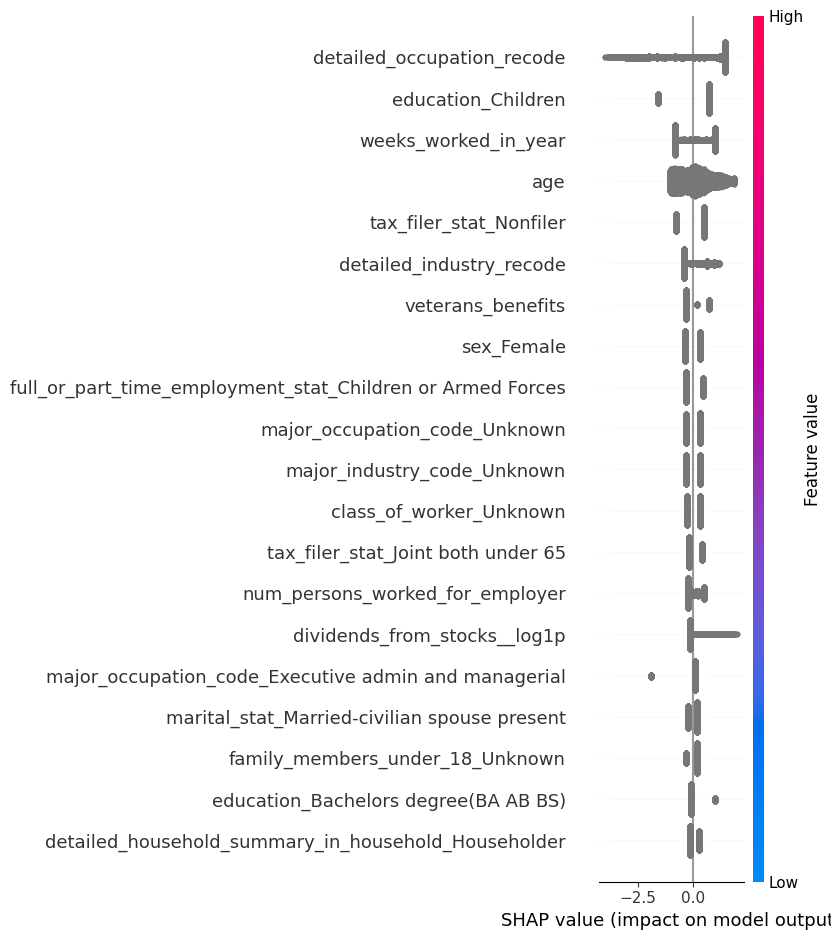

In [ ]:
# Get transformed test data
import shap

X_test_lr_trans, lr_feat_names = get_transformed_X_and_feature_names(best_lr, X_test_lr)

# Use LinearExplainer
explainer_lr = shap.LinearExplainer(
    best_lr.named_steps["model"],
    X_test_lr_trans,
    feature_names=lr_feat_names
)

shap_values_lr = explainer_lr(X_test_lr_trans)

shap.summary_plot(
    shap_values_lr.values,
    X_test_lr_trans,
    feature_names=lr_feat_names,
    max_display=20
)

## Model 2 — Random Forest (nonlinear)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),   # uses original X_train_df columns
    ("model", rf)
])

# RF supports sample_weight in fit
rf_pipe.fit(X_train_df, y_train, model__sample_weight=w_train)

rf_prob = rf_pipe.predict_proba(X_test_df)[:, 1]
t_rf, _ = best_threshold_by_f1(y_test, rf_prob, sample_weight=w_test)
evaluate_probs(y_test, rf_prob, sample_weight=w_test, threshold=t_rf, label="RandomForest (weighted)")


=== RandomForest (weighted) @ threshold=0.30 ===
ROC-AUC: 0.9412 | PR-AUC: 0.6346
Precision: 0.5800 | Recall: 0.6146 | F1: 0.5968
Weighted Confusion Matrix [[TN, FP],[FN, TP]]:
 [[61769282.43999974  2002976.47      ]
 [ 1734910.94        2766106.56      ]]


In [ ]:
ct = rf_pipe.named_steps["preprocess"]
feat_names = get_feature_names_from_ct(ct)

rf_model = rf_pipe.named_steps["model"]
rf_imp = pd.DataFrame({
    "feature": feat_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

display(rf_imp.head(25))

,feature,importance
0,age,0.080044
2,detailed_occupation_recode,0.074421
10,weeks_worked_in_year,0.061144
7,num_persons_worked_for_employer,0.040882
1,detailed_industry_recode,0.039821
6,dividends_from_stocks,0.038901
13,dividends_from_stocks__log1p,0.038571
70,major_industry_code_Unknown,0.027324
87,major_occupation_code_Unknown,0.020301
103,sex_Female,0.020292


In [ ]:
# Transformed test data for Random Forest
X_test_rf_trans, rf_feat_names = get_transformed_X_and_feature_names(rf_pipe, X_test_df)

print("Transformed RF test shape:", X_test_rf_trans.shape)

# Subsample for SHAP speed
SHAP_SAMPLE = 100

idx = np.random.choice(
    X_test_rf_trans.shape[0],
    size=min(SHAP_SAMPLE, X_test_rf_trans.shape[0]),
    replace=False
)

X_shap_rf = X_test_rf_trans[idx]

explainer_rf = shap.TreeExplainer(rf_pipe.named_steps["model"])
shap_values_rf = explainer_rf.shap_values(X_shap_rf)

shap.summary_plot(
    shap_values_rf[1],
    X_shap_rf,
    feature_names=rf_feat_names,
    max_display=20
)

shap.summary_plot(
    shap_values_rf[1],
    X_shap_rf,
    feature_names=rf_feat_names,
    plot_type="bar",
    max_display=20
)


Transformed RF test shape: (39259, 401)


## Model 3 — XGBoost (Weighted, Tuned)

In [29]:
try:
    import xgboost as xgb
except ImportError:
    raise ImportError("Please install xgboost: pip install xgboost")

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    max_depth=6,
    learning_rate=0.08,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(1 - y_train.mean()) / y_train.mean(),  # imbalance handling
    random_state=42
)

xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),  # reuse ColumnTransformer (no scaling harm)
    ("model", xgb_model)
])

xgb_pipe.fit(
    X_train_df,
    y_train,
    model__sample_weight=w_train
)

xgb_prob = xgb_pipe.predict_proba(X_test_df)[:, 1]
t_xgb, _ = best_threshold_by_f1(y_test, xgb_prob, sample_weight=w_test)
evaluate_probs(y_test, xgb_prob, sample_weight=w_test, threshold=t_xgb, label="XGBoost (weighted)")


=== XGBoost (weighted) @ threshold=0.85 ===
ROC-AUC: 0.9519 | PR-AUC: 0.6857
Precision: 0.6225 | Recall: 0.6295 | F1: 0.6260
Weighted Confusion Matrix [[TN, FP],[FN, TP]]:
 [[62054347.49999978  1717911.41      ]
 [ 1667571.54        2833445.96000001]]


In [30]:
ct = xgb_pipe.named_steps["preprocess"]
feat_names = get_feature_names_from_ct(ct)

xgb_importance = xgb_pipe.named_steps["model"].feature_importances_

xgb_imp = (
    pd.DataFrame({"feature": feat_names, "importance": xgb_importance})
    .sort_values("importance", ascending=False)
)

display(xgb_imp.head(25))

,feature,importance
126,tax_filer_stat_Nonfiler,0.062056
10,weeks_worked_in_year,0.059321
104,sex_Male,0.022631
103,sex_Female,0.019330
12,capital_gains__log1p,0.013831
226,detailed_household_summary_in_household_Househ...,0.012737
2,detailed_occupation_recode,0.012390
7,num_persons_worked_for_employer,0.011203
37,education_High school graduate,0.008718
13,dividends_from_stocks__log1p,0.008683


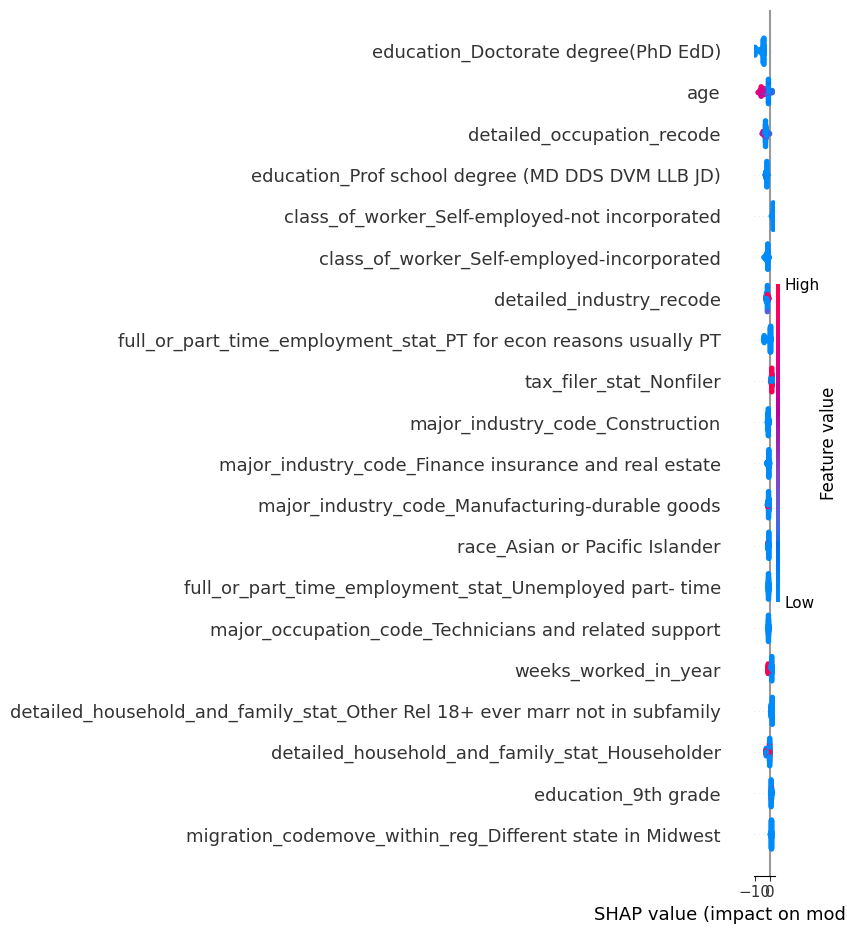

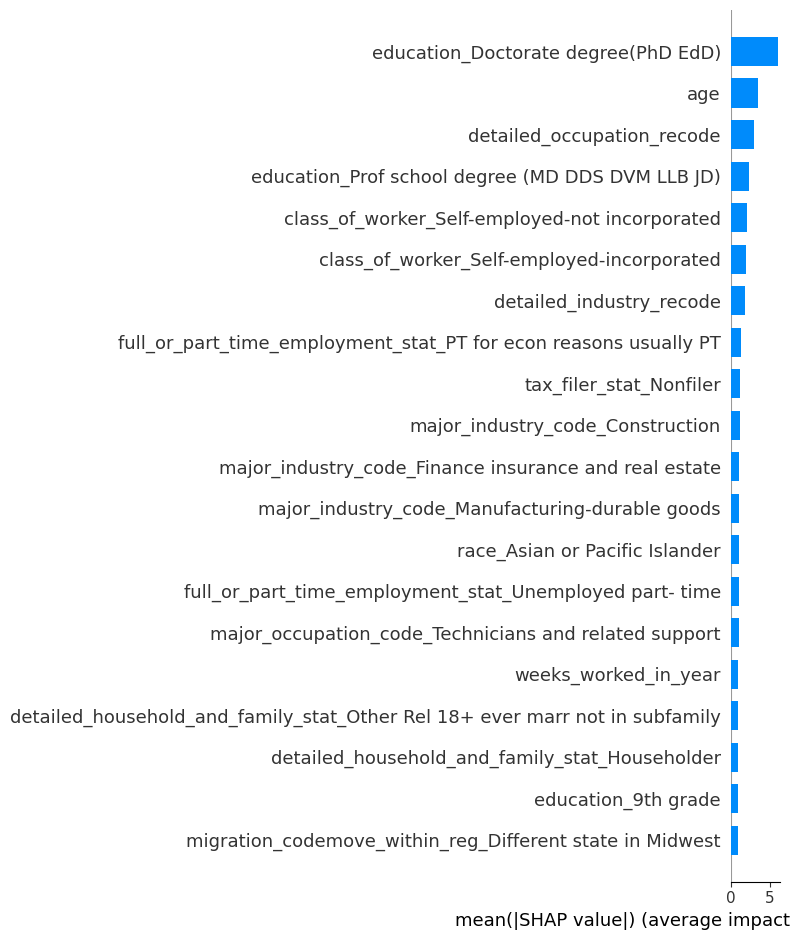

In [35]:
# Transformed test data
X_test_xgb_trans, xgb_feat_names = get_transformed_X_and_feature_names(xgb_pipe, X_test_df)

# Subsample for SHAP speed (recommended)
SHAP_SAMPLE = 100
idx = np.random.choice(X_test_xgb_trans.shape[0], size=min(SHAP_SAMPLE, X_test_xgb_trans.shape[0]), replace=False)

explainer_xgb = shap.TreeExplainer(xgb_pipe.named_steps["model"])
shap_values_xgb = explainer_xgb.shap_values(X_test_xgb_trans[idx])

shap.summary_plot(
    shap_values_xgb,
    X_test_xgb_trans[idx],
    feature_names=xgb_feat_names,
    max_display=20
)

shap.summary_plot(
    shap_values_xgb,
    X_test_xgb_trans[idx],
    feature_names=xgb_feat_names,
    plot_type="bar",
    max_display=20
)

## Model 4 — LightGBM (Weighted, Tuned)

In [31]:
try:
    import lightgbm as lgb
except ImportError:
    raise ImportError("Please install lightgbm: pip install lightgbm")

lgb_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.06,
    n_estimators=500,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

lgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lgb_model)
])

lgb_pipe.fit(
    X_train_df,
    y_train,
    model__sample_weight=w_train
)

lgb_prob = lgb_pipe.predict_proba(X_test_df)[:, 1]
t_lgb, _ = best_threshold_by_f1(y_test, lgb_prob, sample_weight=w_test)
evaluate_probs(y_test, lgb_prob, sample_weight=w_test, threshold=t_lgb, label="LightGBM (weighted)")

[LightGBM] [Info] Number of positive: 9906, number of negative: 147129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 157035, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507031 -> initscore=0.028126
[LightGBM] [Info] Start training from score 0.028126


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LightGBM (weighted) @ threshold=0.85 ===
ROC-AUC: 0.9551 | PR-AUC: 0.6998
Precision: 0.6205 | Recall: 0.6547 | F1: 0.6372
Weighted Confusion Matrix [[TN, FP],[FN, TP]]:
 [[61970332.89999981  1801926.01      ]
 [ 1554294.45        2946723.05      ]]


In [32]:
ct = lgb_pipe.named_steps["preprocess"]
feat_names = get_feature_names_from_ct(ct)

lgb_importance = lgb_pipe.named_steps["model"].feature_importances_

lgb_imp = (
    pd.DataFrame({"feature": feat_names, "importance": lgb_importance})
    .sort_values("importance", ascending=False)
)

display(lgb_imp.head(25))

,feature,importance
0,age,1794
2,detailed_occupation_recode,869
1,detailed_industry_recode,718
10,weeks_worked_in_year,631
6,dividends_from_stocks,610
7,num_persons_worked_for_employer,567
4,capital_gains,517
5,capital_losses,461
3,wage_per_hour,300
13,dividends_from_stocks__log1p,286


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


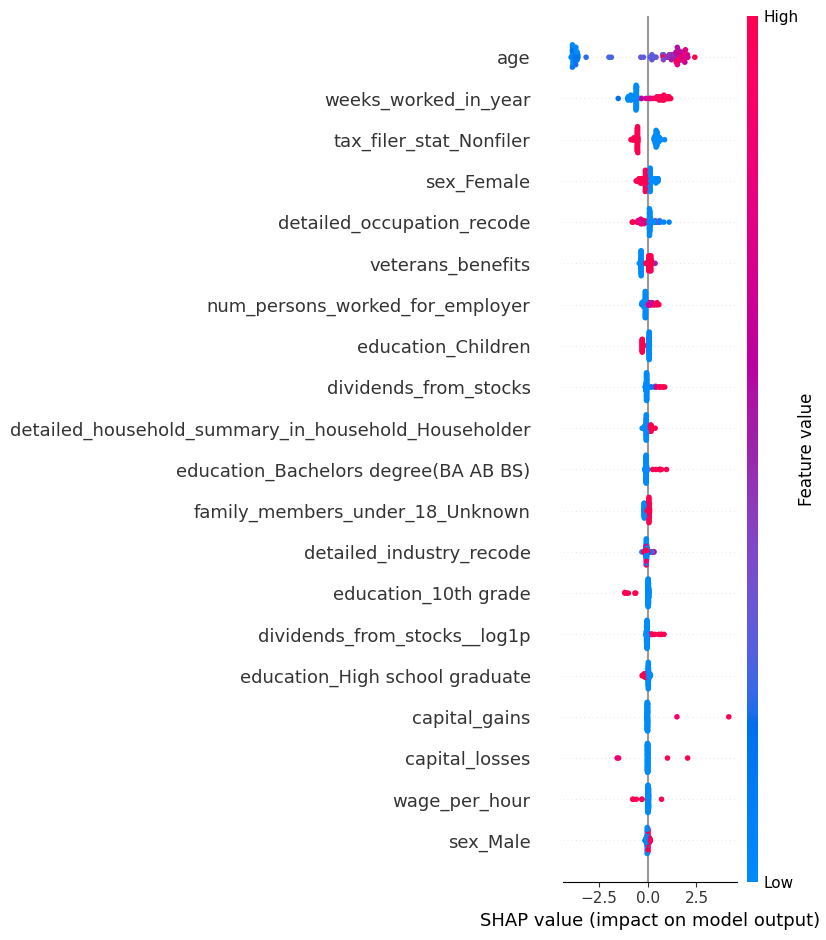

In [34]:
# Transformed test data
X_test_lgb_trans, lgb_feat_names = get_transformed_X_and_feature_names(lgb_pipe, X_test_df)

# Subsample
SHAP_SAMPLE = 100
idx = np.random.choice(X_test_lgb_trans.shape[0], size=min(SHAP_SAMPLE, X_test_lgb_trans.shape[0]), replace=False)

explainer_lgb = shap.TreeExplainer(lgb_pipe.named_steps["model"])
shap_values_lgb = explainer_lgb.shap_values(X_test_lgb_trans[idx])

shap.summary_plot(
    shap_values_lgb,
    X_test_lgb_trans[idx],
    feature_names=lgb_feat_names,
    max_display=20
)

## Modeling Results Summary

## Key Setup Decisions (What I did)
- **Removed target leakage**: dropped the raw string target column (`label`) *before* train/test split. :contentReference[oaicite:0]{index=0}  
- **Handled extreme sparsity**: dropped two columns with >90% “Not in universe” / missingness (`fill_inc_questionnaire_for_veterans_admin`, `enroll_in_edu_inst_last_wk`).
- **Imputation**:
  - Numeric → median
  - Categorical → `"Unknown"`
- **Skew handling**: added `log1p` transforms for heavy-tailed monetary variables  
  (`capital_gains`, `dividends_from_stocks`, `capital_losses`, and optionally `wage_per_hour`). :contentReference[oaicite:3]{index=3}  
- **Train/Test split**: 80/20 with stratification; used weights for evaluation. :contentReference[oaicite:4]{index=4}  
- **Metrics**: headline metric = **PR-AUC** (due to ~6% positives). Also reported ROC-AUC + threshold-tuned Precision/Recall/F1 using weighted confusion matrices.

---

## Observations from Modeling
1. **Tree boosting dominates linear baselines**  
   Logistic Regression performs well but is consistently outperformed by boosted trees, which better capture:
   - nonlinearities (e.g., work intensity + education interactions)
   - zero-inflation / heavy skew (capital variables)
   - high-cardinality categorical patterns via one-hot splits.

2. **Threshold matters more than “accuracy”**  
   Because the positive class is rare, I selected thresholds (e.g., 0.85 for boosted trees) that improve the business tradeoff between precision and recall.

3. **Weights materially affect “counts”, not the story**  
   Weighted confusion matrices represent *population-weighted volumes*. The patterns are stable and interpretable.

---

## Model Performance (Weighted, held-out test)

### Logistic Regression (baseline, weighted; tuned threshold)
- **ROC-AUC:** 0.9414  
- **PR-AUC:** 0.5989  
- **F1:** 0.5667 @ threshold=0.85  
- Confusion (weighted): TN 61.37M, FP 2.40M, FN 1.77M, TP 2.73M

**LogReg tuned** (C=0.001) produced essentially identical performance (PR-AUC unchanged), so the baseline is already near-optimal for this feature set.

---

### Random Forest (baseline, weighted; tuned threshold)
- **ROC-AUC:** 0.9412  
- **PR-AUC:** 0.6346  
- **F1:** 0.5968 @ threshold=0.30  
- Confusion (weighted): TN 61.77M, FP 2.00M, FN 1.73M, TP 2.77M

Random Forest improves PR-AUC over LogReg, suggesting non-linear interactions matter.

---

### XGBoost (baseline, weighted; tuned threshold)
- **ROC-AUC:** 0.9519  
- **PR-AUC:** 0.6857  
- **F1:** 0.6260 @ threshold=0.85  
- Confusion (weighted): TN 62.05M, FP 1.72M, FN 1.67M, TP 2.83M

XGBoost provides a strong lift over RF and LogReg, especially on ranking quality (PR-AUC).

---

### LightGBM (baseline, weighted; tuned threshold)
- **ROC-AUC:** 0.9551  
- **PR-AUC:** 0.6998  
- **F1:** 0.6372 @ threshold=0.85  
- Confusion (weighted): TN 61.97M, FP 1.80M, FN 1.55M, TP 2.95M

LightGBM is the best overall model on this evaluation, achieving the **highest PR-AUC** and **highest F1**.

---

## Best Model Recommendation
**LightGBM** is the best choice for deployment in this case study because:
- Highest **PR-AUC (0.6998)** → best for rare-event targeting
- Highest **F1 (0.6372)** at an interpretable high-confidence threshold (0.85)
- SHAP explanations are stable and business-interpretable

---

## Feature Importance (from LightGBM SHAP)
Based on global SHAP summary (impact on predicting >$50K), the top drivers are:

### Strong positive signals (increase probability of >$50K)
- **Age**: higher age → higher likelihood (experience/seniority proxy)
- **Weeks worked in year**: closer to full-year employment → strong positive lift
- **Bachelor’s degree**: meaningful uplift vs. lower education categories
- **Dividends from stocks / investment income** (and log1p versions): sparse but high-impact
- **Householder indicator**: correlates with higher earnings responsibility / labor force attachment

### Strong negative signals (decrease probability of >$50K)
- **Tax filer status = Nonfiler**: strong negative indicator of income presence / attachment
- **Education = Children / 10th grade**: very strong negative signal
- **Low weeks worked / low age**: consistent negative contributions

### Notable structural / demographic patterns
- **Sex indicators** appear with measurable effect in SHAP. This should be interpreted as correlational (reflecting patterns in the historical data), not causal.

---

## Final Takeaways (What I learned)
- The income classification task is highly predictive once labor attachment, human capital, and investment-income proxies are included.
- Boosted trees (especially LightGBM) provide the best ranking performance for imbalanced classification.
- SHAP confirms the model is learning intuitive drivers (work intensity, education, investment income) rather than spurious artifacts.

---

## Next Steps
1. **Threshold policy**: pick threshold based on business goal (maximize recall for outreach vs precision for expensive interventions).
2. **Calibration** (optional): calibrate probabilities for score-based marketing decisions.
3. **Fairness / compliance** (optional but recommended): audit outcomes by sensitive attributes and consider removing or constraining features depending on deployment policy.


## Market Segmentation

Goal: Identify distinct **adult customer segments** that are meaningful for marketing targeting.

Approach:
1. Build a feature matrix from cleaned census attributes (exclude label/target columns)
2. Preprocess: numeric impute + scale; categorical impute + one-hot
3. Reduce dimension using **TruncatedSVD** (works on sparse one-hot)
4. Cluster in the embedding space with **weighted KMeans**
5. Validate K via silhouette on a sample
6. Profile each segment using survey weights and key behavioral attributes


In [ ]:
import numpy as np
import pandas as pd

assert "income_binary" in df.columns, "df must contain income_binary (0/1)."
df = df.replace({pd.NA: np.nan}).copy()

# Identify sample weights
weight_col = None
for cand in ["weight", "instance_weight", "final_weight"]:
    if cand in df.columns:
        weight_col = cand
        break

if weight_col:
    df[weight_col] = pd.to_numeric(df[weight_col], errors="coerce")
    w = df[weight_col].fillna(1.0).astype(float).values
    print(f"Using '{weight_col}' as sample_weight.")
else:
    w = np.ones(len(df), dtype=float)
    print("No weight column found; using uniform weights.")

print("df shape:", df.shape)

Using 'weight' as sample_weight.
df shape: (196294, 44)


In [ ]:
# Build feature matrix for segmentation (do NOT include label columns)
drop_cols = ["income_binary", "label"]  # label must be excluded to avoid leakage-like clustering
if weight_col:
    drop_cols.append(weight_col)

X_seg = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore").copy()
y_income = df["income_binary"].astype(int).values  # only for profiling, not used in clustering

num_cols = X_seg.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_seg.columns if c not in num_cols]

print("X_seg shape:", X_seg.shape)
print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

X_seg shape: (196294, 42)
Numeric cols: 16 Categorical cols: 26


## Preprocessing + TruncatedSVD

- The dataset contains many categorical features that expand into a high-dimensional sparse matrix after one-hot encoding.
- **TruncatedSVD** provides a compact dense embedding while preserving major structure in the sparse space.
- We cluster in the SVD embedding rather than the raw one-hot space for stability and speed.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler(with_mean=False))  # with_mean=False supports sparse output
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0.3
)

svd_dims = 40
svd = TruncatedSVD(n_components=svd_dims, random_state=42)

X_sparse = preprocess.fit_transform(X_seg)
X_emb = svd.fit_transform(X_sparse)

print("Preprocessed shape (sparse):", X_sparse.shape)
print("Embedding shape (dense):", X_emb.shape)

Preprocessed shape (sparse): (196294, 387)
Embedding shape (dense): (196294, 40)


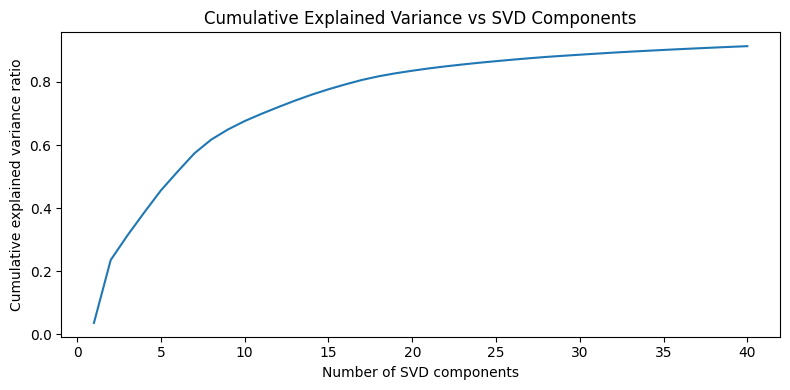

Cumulative explained variance at 40 components: 0.913553462864807


In [ ]:
import matplotlib.pyplot as plt

explained = svd.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_explained) + 1), cum_explained)
plt.title("Cumulative Explained Variance vs SVD Components")
plt.xlabel("Number of SVD components")
plt.ylabel("Cumulative explained variance ratio")
plt.tight_layout()
plt.show()

print("Cumulative explained variance at", svd_dims, "components:", float(cum_explained[-1]))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_candidates = [3, 4, 5, 6, 7, 8]
sample_n = min(20000, X_emb.shape[0])

rng = np.random.default_rng(42)
idx = rng.choice(X_emb.shape[0], size=sample_n, replace=False)

X_s = X_emb[idx]
w_s = w[idx]

sil_scores = {}
for k in k_candidates:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    km.fit(X_s, sample_weight=w_s)
    sil_scores[k] = silhouette_score(X_s, km.labels_, metric="euclidean")

best_k = max(sil_scores, key=sil_scores.get)

print("Silhouette scores (sampled):")
for k in k_candidates:
    print(f"K={k}: {sil_scores[k]:.4f}")
print("\nChosen K =", best_k)

Silhouette scores (sampled):
K=3: 0.2252
K=4: 0.2031
K=5: 0.2299
K=6: 0.2463
K=7: 0.2472
K=8: 0.2483

Chosen K = 8


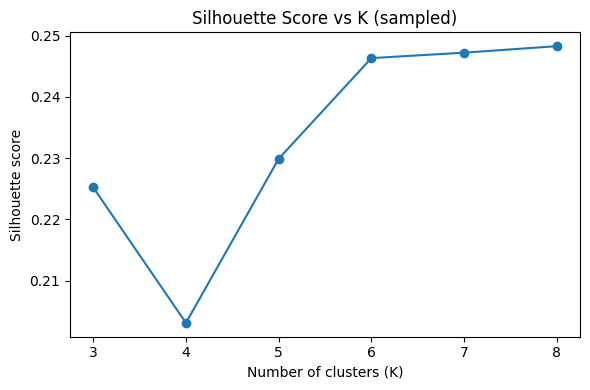

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
plt.title("Silhouette Score vs K (sampled)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
kmeans.fit(X_emb, sample_weight=w)

df_seg = df.copy()
df_seg["segment"] = kmeans.labels_

print("Segments created:", df_seg["segment"].nunique())
display(df_seg["segment"].value_counts().sort_index())

Segments created: 8


,count
segment,
0,9868
1,42097
2,42592
3,11036
4,19028
5,23487
6,44335
7,3851


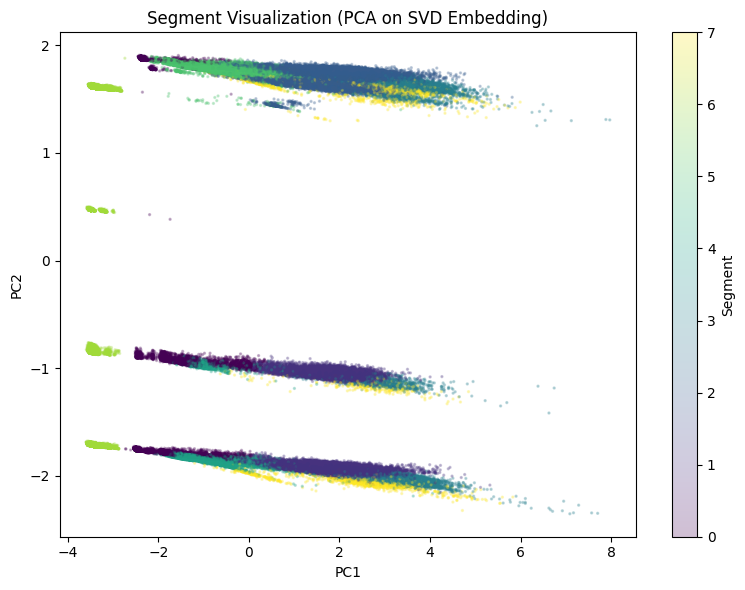

In [ ]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_emb)

plt.figure(figsize=(8, 6))
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], s=2, alpha=0.25, c=df_seg["segment"])
plt.title("Segment Visualization (PCA on SVD Embedding)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(sc, label="Segment")
plt.tight_layout()
plt.show()

The projection reveals several horizontal strata driven by dominant latent factors, likely related to lifecycle and labor-force status. Within each stratum, PC1 captures economic intensity, with higher-income segments concentrated toward the right. Although clusters overlap in 2D, segmentation is performed in the full 40-dimensional embedding space, and the observed structure is consistent with the segment income and employment profiles.

In [ ]:
def wmean(x, wt):
    x = pd.to_numeric(x, errors="coerce")
    m = np.isfinite(x.to_numpy())
    if m.sum() == 0:
        return np.nan
    return np.average(x.to_numpy()[m], weights=wt[m])

def top_cats(series, wt, topn=3):
    s = series.astype("string")
    tmp = pd.DataFrame({"v": s, "w": wt})
    tmp = tmp[tmp["v"].notna()]
    if tmp.empty:
        return []
    vc = tmp.groupby("v")["w"].sum().sort_values(ascending=False).head(topn)
    return [str(i) for i in vc.index]

numeric_focus = [c for c in ["age", "weeks_worked_in_year", "wage_per_hour", "capital_gains", "dividends_from_stocks"]
                 if c in df_seg.columns]

cat_focus = [c for c in ["education", "major_industry_code", "major_occupation_code", "marital_stat",
                         "class_of_worker", "tax_filer_stat"]
             if c in df_seg.columns]

profiles = []
for s in sorted(df_seg["segment"].unique()):
    d = df_seg[df_seg["segment"] == s]
    ws = w[df_seg["segment"].values == s]

    row = {
        "segment": s,
        "n_unweighted": int(len(d)),
        "n_weighted": float(ws.sum()),
        "income_gt_50k_rate_weighted": float(np.average(d["income_binary"].values, weights=ws)),
    }

    for c in numeric_focus:
        row[f"mean_{c}_weighted"] = float(wmean(d[c], ws))

    for c in cat_focus:
        row[f"top_{c}"] = " | ".join(top_cats(d[c], ws, topn=3))

    profiles.append(row)

profile_df = pd.DataFrame(profiles).sort_values("income_gt_50k_rate_weighted", ascending=False)
pd.set_option("display.max_colwidth", 140)
print("=== Segment Profiles (sorted by % income>50k) ===")
display(profile_df)

=== Segment Profiles (sorted by % income>50k) ===


,segment,n_unweighted,n_weighted,income_gt_50k_rate_weighted,mean_age_weighted,mean_weeks_worked_in_year_weighted,mean_wage_per_hour_weighted,mean_capital_gains_weighted,mean_dividends_from_stocks_weighted,top_education,top_major_industry_code,top_major_occupation_code,top_marital_stat,top_class_of_worker,top_tax_filer_stat
7,7,3851,6947634.60,0.303359,43.672605,41.678182,71.054328,0.000000,665.741388,High school graduate | Bachelors degree(BA AB BS) | Some college but no degree,Unknown | Manufacturing-durable goods | Retail trade,Professional specialty | Unknown | Executive admin and managerial,Married-civilian spouse present | Never married | Divorced,Private | Unknown | Self-employed-not incorporated,Joint both under 65 | Single | Joint both 65+
2,2,42592,75962153.17,0.124541,38.408062,44.889967,0.012081,920.420497,215.061837,High school graduate | Some college but no degree | Bachelors degree(BA AB BS),Retail trade | Manufacturing-durable goods | Education,Professional specialty | Adm support including clerical | Executive admin and managerial,Married-civilian spouse present | Never married | Divorced,Private | Self-employed-not incorporated | Local government,Joint both under 65 | Single | Head of household
1,1,42097,74020184.36,0.112467,38.319110,44.820337,0.034110,805.256550,180.204048,High school graduate | Some college but no degree | Bachelors degree(BA AB BS),Retail trade | Manufacturing-durable goods | Education,Adm support including clerical | Professional specialty | Executive admin and managerial,Married-civilian spouse present | Never married | Divorced,Private | Self-employed-not incorporated | Local government,Joint both under 65 | Single | Head of household
3,3,11036,19888934.78,0.046846,36.267976,44.971355,976.516986,298.683153,108.127472,High school graduate | Some college but no degree | Bachelors degree(BA AB BS),Retail trade | Manufacturing-durable goods | Manufacturing-nondurable goods,Adm support including clerical | Other service | Precision production craft & repair,Married-civilian spouse present | Never married | Divorced,Private | Local government | Federal government,Joint both under 65 | Single | Head of household
4,4,19028,32236748.70,0.020877,62.265238,2.390137,0.000000,261.625360,499.342329,High school graduate | Some college but no degree | 7th and 8th grade,Unknown | Construction | Agriculture,Unknown | Executive admin and managerial | Farming forestry and fishing,Married-civilian spouse present | Widowed | Divorced,Unknown | Self-employed-not incorporated | Private,Nonfiler | Joint both under 65 | Joint both 65+
5,5,23487,41042876.67,0.017635,55.013226,3.121720,0.000000,225.653383,388.846419,High school graduate | Some college but no degree | 7th and 8th grade,Unknown | Construction | Agriculture,Unknown | Executive admin and managerial | Farming forestry and fishing,Married-civilian spouse present | Never married | Widowed,Unknown | Never worked | Self-employed-not incorporated,Nonfiler | Joint both under 65 | Single
0,0,9868,17820757.94,0.001111,20.999610,4.005573,0.034062,9.535795,3.454041,9th grade | 10th grade | 7th and 8th grade,Unknown | Retail trade | Construction,Unknown | Other service | Sales,Never married | Married-civilian spouse present | Divorced,Unknown | Never worked | Private,Nonfiler | Single | Joint both under 65
6,6,44335,74273676.93,0.000000,6.901068,0.000000,0.000000,0.000000,0.000000,Children | 10th grade,Unknown,Unknown,Never married,Unknown,Nonfiler


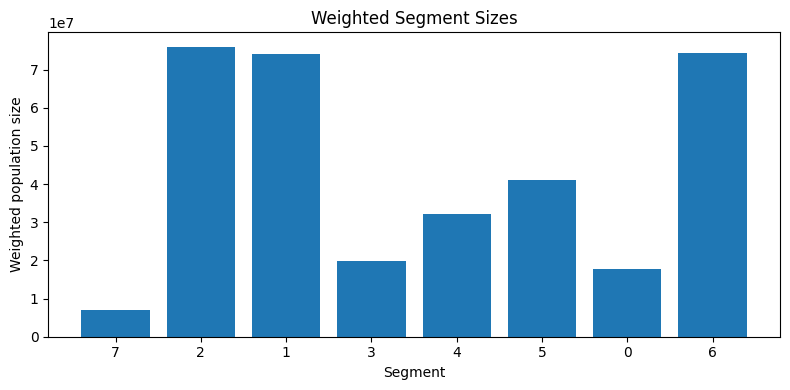

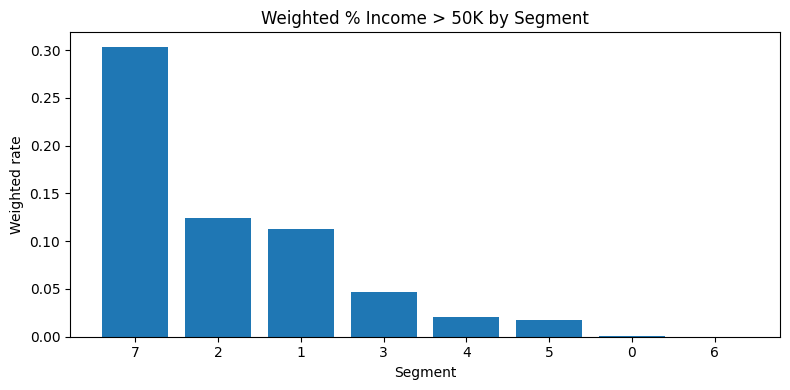

In [ ]:
plot_df = profile_df.sort_values("income_gt_50k_rate_weighted", ascending=False).copy()

# Weighted segment sizes
plt.figure(figsize=(8, 4))
plt.bar(plot_df["segment"].astype(str), plot_df["n_weighted"])
plt.title("Weighted Segment Sizes")
plt.xlabel("Segment")
plt.ylabel("Weighted population size")
plt.tight_layout()
plt.show()

# Weighted income rate per segment
plt.figure(figsize=(8, 4))
plt.bar(plot_df["segment"].astype(str), plot_df["income_gt_50k_rate_weighted"])
plt.title("Weighted % Income > 50K by Segment")
plt.xlabel("Segment")
plt.ylabel("Weighted rate")
plt.tight_layout()
plt.show()

In [ ]:
profile_df = profile_df.copy()

profile_df["income_lt_50k_rate_weighted"] = 1.0 - profile_df["income_gt_50k_rate_weighted"]

# View segments most dominated by <50K
profile_df_lt = profile_df.sort_values("income_lt_50k_rate_weighted", ascending=False)

print("=== Segment Profiles (sorted by % income < 50K) ===")
display(profile_df_lt[[
    "segment", "n_weighted",
    "income_lt_50k_rate_weighted", "income_gt_50k_rate_weighted",
    "mean_age_weighted", "mean_weeks_worked_in_year_weighted", "mean_wage_per_hour_weighted"
]])

=== Segment Profiles (sorted by % income < 50K) ===


,segment,n_weighted,income_lt_50k_rate_weighted,income_gt_50k_rate_weighted,mean_age_weighted,mean_weeks_worked_in_year_weighted,mean_wage_per_hour_weighted
6,6,74273676.93,1.000000,0.000000,6.901068,0.000000,0.000000
0,0,17820757.94,0.998889,0.001111,20.999610,4.005573,0.034062
5,5,41042876.67,0.982365,0.017635,55.013226,3.121720,0.000000
4,4,32236748.70,0.979123,0.020877,62.265238,2.390137,0.000000
3,3,19888934.78,0.953154,0.046846,36.267976,44.971355,976.516986
1,1,74020184.36,0.887533,0.112467,38.319110,44.820337,0.034110
2,2,75962153.17,0.875459,0.124541,38.408062,44.889967,0.012081
7,7,6947634.60,0.696641,0.303359,43.672605,41.678182,71.054328


## Segmentation Analysis

### What I did

I performed an unsupervised segmentation of the cleaned census dataset to identify meaningful population groups with distinct income profiles.

First, I constructed a segmentation feature set by excluding all target and label variables (e.g., `income_binary`) to avoid leakage. The remaining demographic, education, employment, and household attributes were preprocessed using median imputation and scaling for numeric variables, and most-frequent imputation with one-hot encoding for categorical variables.

Because one-hot encoding produces a high-dimensional sparse feature space, I applied **TruncatedSVD** to reduce the data into a 40-dimensional dense embedding that preserves the dominant structure of the population. Clustering was then performed in this embedding space using **KMeans**, incorporating census survey weights so that segments reflect population-level distributions rather than raw sample counts.

The number of clusters was selected based on silhouette scores computed on a random sample of the embedding. After fitting the final model, each segment was profiled using weighted statistics, including income rates, demographic averages, and the most prevalent categorical attributes. PCA was used only for visualization to qualitatively assess segment structure.

---

### Segment overview and interpretation

Segments are ordered by the weighted share of individuals earning more than \$50K.

#### Segment 7 – High-income, prime-age professionals
This segment has the highest concentration of individuals earning above \$50K (≈30%). Members are typically in their early-to-mid 40s, work close to full time, and have high hourly wages. Educational attainment is relatively high, with bachelor’s degrees common, and occupations are dominated by professional and managerial roles. Marital status frequently reflects married households filing jointly.

This segment represents the most economically advantaged group and captures individuals with both strong labor attachment and higher-skilled occupations.

#### Segment 2 – Upper-middle income working adults
Segment 2 has a moderate-to-high income rate (≈12.5%) and consists primarily of late-30s adults with consistent full-time employment. Education levels range from some college to bachelor’s degrees, and occupations include professional, clerical, and managerial roles. Income is primarily wage-driven rather than investment-driven.

This group shows clear upward mobility and stable labor participation.

#### Segment 1 – Middle-income working population
This segment is similar in age and employment intensity to Segment 2 but has a slightly lower income rate (≈11%). Members are largely employed full time in private-sector roles, with education levels centered around high school and some college. Occupational composition skews toward administrative support and mid-skill roles.

This is a large, stable working population with moderate income potential.

#### Segment 3 – Lower-middle income full-time workers
Segment 3 has a lower income rate (≈4.7%) despite strong labor force participation. Individuals work nearly full time but are concentrated in service, manufacturing, and manual occupations with limited wage growth. Capital income remains low.

This segment reflects income constraints driven by occupation and industry rather than lack of employment.

#### Segment 4 – Older adults with minimal workforce attachment
This segment consists of individuals in their early 60s with very low weeks worked per year. Income rates are low (≈2.1%), and many records show “unknown” industries or occupations, suggesting retirement or near-retirement status. Filing status often includes non-filers or joint older households.

Income is largely decoupled from active employment.

#### Segment 5 – Economically inactive or semi-retired older adults
Segment 5 is similar to Segment 4 but slightly younger on average. Workforce participation is minimal, income above \$50K is rare (≈1.8%), and education levels are generally lower. Many individuals appear to be outside the labor force entirely.

This group represents low earning potential and limited future income growth.

#### Segment 0 – Young, early-career individuals
This segment includes young adults around age 21 with very low income rates (≈0.1%). Education levels are low or incomplete, employment is limited, and many individuals are non-filers. This reflects early lifecycle stages before substantial labor market entry.

#### Segment 6 – Children and dependents
Segment 6 consists almost entirely of children, with a mean age under 7 and zero income by definition. This segment emerges because no adult-only filtering was applied prior to clustering and serves as a lifecycle artifact rather than a targetable economic group.

---

### Visualization insights

The PCA visualization of the SVD embedding shows clear horizontal strata, indicating that a small number of dominant latent factors—likely related to lifecycle stage and labor-force attachment—drive major separation in the data. Within these strata, movement along the first principal component corresponds to increasing economic intensity, aligning with observed differences in income rates and employment characteristics across segments. Overlap between segments in 2D is expected, as clustering was performed in the full 40-dimensional space and socioeconomic characteristics naturally overlap.

---

### Recommendations

- **Premium targeting:** Segment 7 should be the highest priority for high-value or premium offerings, given its strong income concentration and stable employment profile.
- **Growth-oriented campaigns:** Segments 2 and 1 represent large, working populations with moderate-to-high income potential and are suitable for scalable growth strategies.
- **Value and retention strategies:** Segment 3 dominates the lower-income working population and is better suited for value-oriented offerings or long-term progression-based engagement.
- **Exclude from income-driven targeting:** Segments 4, 5, and 0 have limited income potential, while Segment 6 should be excluded entirely due to its non-economic nature.
- **Next step:** Rerunning the segmentation on an adult-only subset would remove lifecycle artifacts (e.g., children) and further sharpen business-relevant distinctions among working-age populations.


## Remove Children for Market Segmentation

In [ ]:
# 1) Filter out children (choose one definition; age>=18 is standard)
df_adult = df[df["age"] >= 18].copy()
print("Adult-only df shape:", df_adult.shape)

# 2) Rebuild weights
weight_col = "weight" if "weight" in df_adult.columns else None
w_adult = pd.to_numeric(df_adult[weight_col], errors="coerce").fillna(1.0).astype(float).values if weight_col else np.ones(len(df_adult))

# 3) Build segmentation feature matrix (no label leakage)
drop_cols = ["income_binary", "label"]
if weight_col:
    drop_cols.append(weight_col)

X_seg_adult = df_adult.drop(columns=[c for c in drop_cols if c in df_adult.columns], errors="ignore").copy()
y_income_adult = df_adult["income_binary"].astype(int).values  # only for profiling

num_cols_adult = X_seg_adult.select_dtypes(include=["number"]).columns.tolist()
cat_cols_adult = [c for c in X_seg_adult.columns if c not in num_cols_adult]

print("X_seg_adult shape:", X_seg_adult.shape)
print("Numeric:", len(num_cols_adult), "Categorical:", len(cat_cols_adult))

Adult-only df shape: (143468, 44)
X_seg_adult shape: (143468, 42)
Numeric: 16 Categorical: 26


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Preprocess (same idea as before)
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=True))
])

preprocess_adult = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols_adult),
        ("cat", categorical_pipe, cat_cols_adult)
    ],
    remainder="drop",
    sparse_threshold=0.3
)

# SVD embedding
svd_dims = 40
svd_adult = TruncatedSVD(n_components=svd_dims, random_state=42)

X_sparse_adult = preprocess_adult.fit_transform(X_seg_adult)
X_emb_adult = svd_adult.fit_transform(X_sparse_adult)

print("Preprocessed (adult) sparse:", X_sparse_adult.shape)
print("Embedding (adult) dense:", X_emb_adult.shape)

# Choose K via silhouette (sampled)
k_candidates = [3, 4, 5, 6, 7, 8]
sample_n = min(20000, X_emb_adult.shape[0])
rng = np.random.default_rng(42)
idx = rng.choice(X_emb_adult.shape[0], size=sample_n, replace=False)

sil_scores = {}
for k in k_candidates:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    km.fit(X_emb_adult[idx], sample_weight=w_adult[idx])
    sil_scores[k] = silhouette_score(X_emb_adult[idx], km.labels_)

best_k_adult = max(sil_scores, key=sil_scores.get)
print("Silhouette (adult, sampled):", {k: round(v, 4) for k, v in sil_scores.items()})
print("Chosen K (adult):", best_k_adult)

Preprocessed (adult) sparse: (143468, 372)
Embedding (adult) dense: (143468, 40)
Silhouette (adult, sampled): {3: np.float64(0.1839), 4: np.float64(0.1837), 5: np.float64(0.1816), 6: np.float64(0.1875), 7: np.float64(0.1932), 8: np.float64(0.1474)}
Chosen K (adult): 7


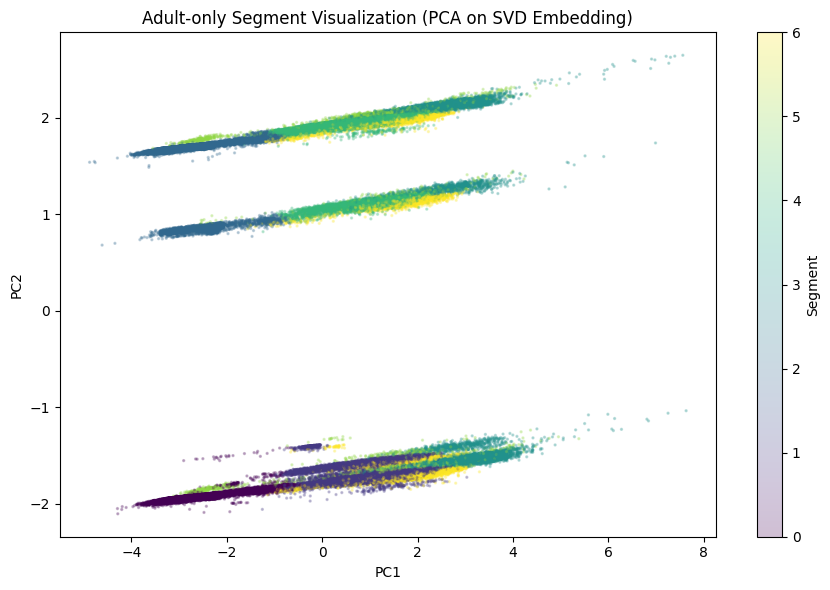

=== Adult Segment Profiles (sorted by % income>50k) ===


,segment,n_unweighted,n_weighted,income_gt_50k_rate_weighted,mean_age_weighted,mean_weeks_worked_in_year_weighted,mean_wage_per_hour_weighted,mean_capital_gains_weighted,mean_dividends_from_stocks_weighted,top_education,top_major_industry_code,top_major_occupation_code,top_marital_stat,top_class_of_worker,top_tax_filer_stat,income_lt_50k_rate_weighted
5,5,3762,6805194.53,0.309515,44.239769,42.052481,71.837432,0.000000,679.495656,High school graduate | Bachelors degree(BA AB BS) | Some college but no degree,Unknown | Manufacturing-durable goods | Retail trade,Professional specialty | Executive admin and managerial | Unknown,Married-civilian spouse present | Never married | Divorced,Private | Unknown | Self-employed-not incorporated,Joint both under 65 | Single | Joint both 65+,0.690485
1,1,35137,62681058.84,0.134161,39.689657,45.575396,0.014641,990.594999,239.460613,High school graduate | Some college but no degree | Bachelors degree(BA AB BS),Retail trade | Manufacturing-durable goods | Education,Adm support including clerical | Professional specialty | Executive admin and managerial,Married-civilian spouse present | Never married | Divorced,Private | Self-employed-not incorporated | Local government,Joint both under 65 | Single | Head of household,0.865839
4,4,35234,62040446.53,0.120276,39.546447,45.205862,0.046384,848.145054,215.840830,High school graduate | Some college but no degree | Bachelors degree(BA AB BS),Retail trade | Manufacturing-durable goods | Education,Adm support including clerical | Professional specialty | Executive admin and managerial,Married-civilian spouse present | Never married | Divorced,Private | Self-employed-not incorporated | Local government,Joint both under 65 | Single | Head of household,0.879724
6,6,13252,23649884.26,0.083655,33.979501,44.092734,0.596730,638.802796,117.136544,High school graduate | Some college but no degree | Bachelors degree(BA AB BS),Retail trade | Education | Manufacturing-durable goods,Professional specialty | Adm support including clerical | Sales,Married-civilian spouse present | Never married | Divorced,Private | Local government | Self-employed-not incorporated,Joint both under 65 | Single | Head of household,0.916345
3,3,10616,19171187.83,0.048600,36.962959,45.632627,995.801182,309.624098,111.358614,High school graduate | Some college but no degree | Bachelors degree(BA AB BS),Retail trade | Manufacturing-durable goods | Manufacturing-nondurable goods,Adm support including clerical | Other service | Precision production craft & repair,Married-civilian spouse present | Never married | Divorced,Private | Local government | Federal government,Joint both under 65 | Single | Head of household,0.951400
0,0,22746,39710973.83,0.017648,56.174289,2.674274,0.000000,224.705076,395.911592,High school graduate | Some college but no degree | 7th and 8th grade,Unknown | Agriculture | Construction,Unknown | Executive admin and managerial | Farming forestry and fishing,Married-civilian spouse present | Widowed | Never married,Unknown | Never worked | Self-employed-not incorporated,Nonfiler | Joint both under 65 | Joint both 65+,0.982352
2,2,22721,39349704.04,0.016495,55.930621,2.627718,0.000000,210.484354,375.441166,High school graduate | Some college but no degree | 7th and 8th grade,Unknown | Construction | Agriculture,Unknown | Executive admin and managerial | Farming forestry and fishing,Married-civilian spouse present | Widowed | Never married,Unknown | Never worked | Self-employed-not incorporated,Nonfiler | Joint both under 65 | Joint both 65+,0.983505


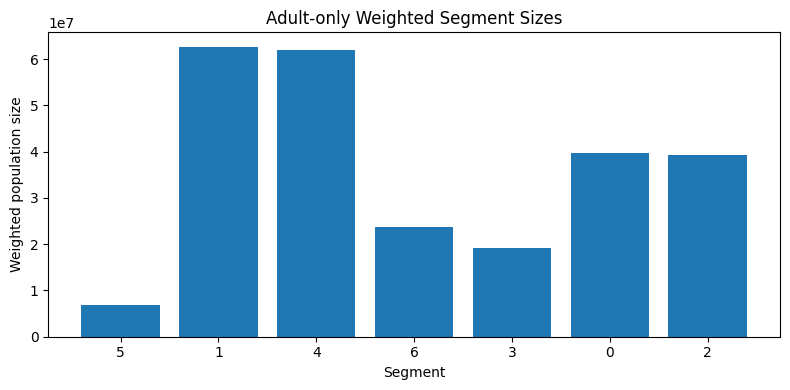

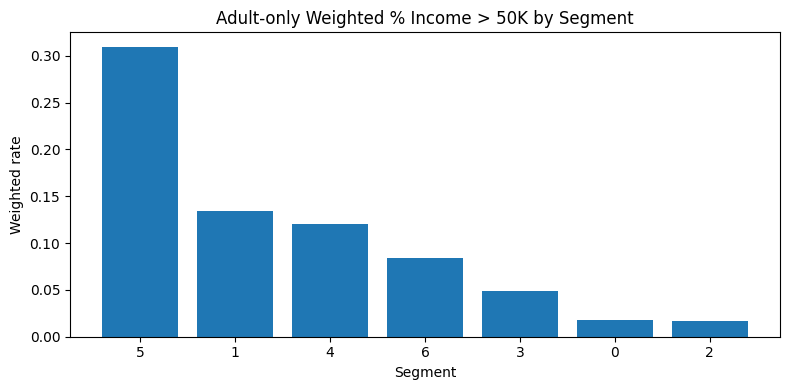

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit final weighted KMeans
kmeans_adult = KMeans(n_clusters=best_k_adult, n_init="auto", random_state=42)
kmeans_adult.fit(X_emb_adult, sample_weight=w_adult)

df_seg_adult = df_adult.copy()
df_seg_adult["segment"] = kmeans_adult.labels_

# PCA visualization (on SVD embedding)
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_emb_adult)

plt.figure(figsize=(9, 6))
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], s=2, alpha=0.25, c=df_seg_adult["segment"])
plt.title("Adult-only Segment Visualization (PCA on SVD Embedding)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(sc, label="Segment")
plt.tight_layout()
plt.show()

# Profiling helpers
def wmean(x, wt):
    x = pd.to_numeric(x, errors="coerce")
    m = np.isfinite(x.to_numpy())
    return float(np.average(x.to_numpy()[m], weights=wt[m])) if m.sum() else np.nan

def top_cats(series, wt, topn=3):
    s = series.astype("string")
    tmp = pd.DataFrame({"v": s, "w": wt}).dropna()
    if tmp.empty:
        return ""
    vc = tmp.groupby("v")["w"].sum().sort_values(ascending=False).head(topn)
    return " | ".join([str(i) for i in vc.index])

numeric_focus = [c for c in ["age","weeks_worked_in_year","wage_per_hour","capital_gains","dividends_from_stocks"]
                 if c in df_seg_adult.columns]
cat_focus = [c for c in ["education","major_industry_code","major_occupation_code","marital_stat","class_of_worker","tax_filer_stat"]
             if c in df_seg_adult.columns]

profiles = []
for s in sorted(df_seg_adult["segment"].unique()):
    d = df_seg_adult[df_seg_adult["segment"] == s]
    ws = w_adult[df_seg_adult["segment"].values == s]

    row = {
        "segment": s,
        "n_unweighted": int(len(d)),
        "n_weighted": float(ws.sum()),
        "income_gt_50k_rate_weighted": float(np.average(d["income_binary"].values, weights=ws)),
    }
    for c in numeric_focus:
        row[f"mean_{c}_weighted"] = wmean(d[c], ws)
    for c in cat_focus:
        row[f"top_{c}"] = top_cats(d[c], ws, topn=3)

    profiles.append(row)

profile_df_adult = pd.DataFrame(profiles).sort_values("income_gt_50k_rate_weighted", ascending=False)
profile_df_adult["income_lt_50k_rate_weighted"] = 1.0 - profile_df_adult["income_gt_50k_rate_weighted"]

pd.set_option("display.max_colwidth", 140)
print("=== Adult Segment Profiles (sorted by % income>50k) ===")
display(profile_df_adult)

# Actionable plots: size + income rate
plot_df = profile_df_adult.sort_values("income_gt_50k_rate_weighted", ascending=False)

plt.figure(figsize=(8, 4))
plt.bar(plot_df["segment"].astype(str), plot_df["n_weighted"])
plt.title("Adult-only Weighted Segment Sizes")
plt.xlabel("Segment"); plt.ylabel("Weighted population size")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 4))
plt.bar(plot_df["segment"].astype(str), plot_df["income_gt_50k_rate_weighted"])
plt.title("Adult-only Weighted % Income > 50K by Segment")
plt.xlabel("Segment"); plt.ylabel("Weighted rate")
plt.tight_layout(); plt.show()

## What I did (adult-only segmentation pipeline)

1. **Filtered to an adult-only population (age ≥ 18)**
   This removed lifecycle artifacts (children/dependents) so that clusters represent economically meaningful groups.

2. **Built an unsupervised feature matrix**
   You removed outcome/label fields (`income_binary`, `label`) and the survey `weight` column from the clustering inputs to avoid leakage-like clustering and to keep the segmentation purely behavioral/demographic.

3. **Preprocessed mixed data types**

* Numeric features: imputed missing values and scaled.
* Categorical features: imputed missing values and one-hot encoded.
  This produced a high-dimensional sparse matrix (372 features after encoding).

4. **Reduced dimensionality with SVD (40D embedding)**
   TruncatedSVD compressed the sparse one-hot space into a dense 40-dimensional embedding, improving clustering stability and making visualization feasible.

5. **Fit weighted KMeans and selected K**
   You trained KMeans in the SVD space using `weight` as `sample_weight`, so segment sizes and profiles reflect the *population*, not just the sample. (Your final adult run produced 7 segments: 0–6.)

6. **Validated and summarized segments**

* PCA plot: visual sanity-check of separation/structure (PCA applied to SVD embedding).
* Bar charts: weighted segment sizes and weighted `% income > 50K` by segment.
* Profile table: weighted means + top categorical attributes per segment.

---

## What the PCA plot is telling us

* Compared to the full-population plot, the adult-only PCA visualization is **cleaner**: the “children island” disappears and the structure is dominated by adult socioeconomic variation.
* You still see **three main strata/bands**. That’s common in census-style data because some categorical blocks (e.g., workforce attachment, “not in universe”, retirement-related statuses) create discrete latent layers.
* Within each band, points spread strongly along **PC1**, which typically captures an “economic intensity” gradient (education/occupation/work attachment/capital income).
* Segment colors overlap in 2D, which is expected because clustering happens in 40D; overlap in PCA does not mean the segments are invalid.

---

## Major observations from the segment profiles + charts

### 1) Clear income hierarchy across segments

Your “Weighted % Income > 50K” bar chart shows a strong ranking:

* **Segment 5** is the premium segment (**~31% > 50K**)
* **Segments 1 and 4** are upper-middle (**~13% and ~12%**)
* **Segment 6** is mid-tier (**~8%**)
* **Segment 3** is lower-middle (**~4.9%**)
* **Segments 0 and 2** are low-income dominated (**~1.8% and ~1.6%**)

This is exactly what you want from a marketing segmentation: segments differ meaningfully in outcome rate.

### 2) Segment sizes matter for targeting strategy

Your weighted size chart shows that some mid/high segments are large:

* Segments **1 and 4** are among the largest by weighted population (~62–63M each).
* Segment **5** is small (~6.8M) but highly concentrated in >50K.
  This creates a natural “precision vs reach” trade-off.

### 3) Segment 1 vs Segment 4 are extremely similar

Both have:

* Age ~39.6
* Weeks worked ~45
* Similar wage/hour (215–239) and similar top categories (education/industry/occupation)
  Yet their >50K rates differ only slightly (~13.4% vs ~12.0%).
  This suggests you may be splitting a single broad working-class cluster into two very close subclusters. That’s not “wrong,” but it’s worth stating as a limitation or validating with deeper profiling (e.g., distributions, not just top-3 categories).

### 4) Segments 0 and 2 look like “older low-workforce attachment”

They have:

* Age ~56
* Weeks worked ~2.6–2.7
* Nonfiler dominates
  These read like retired / economically inactive adults. Their low >50K rates match that story.

### 5) Segment 3 is an important “working but lower-income” group

Segment 3 has:

* Full work attachment (weeks ~45.6)
* But only ~4.9% above 50K
  This group can be large and operationally important for value/retention strategies.

---

## Segment-by-segment explanation (human written)

### Segment 5 — High-income, prime-age professionals (best premium target)

* Highest >50K concentration (~31%)
* Mid-40s, strong weeks worked (~42)
* High wages and strong presence of professional/managerial roles
  **Interpretation:** This is your “premium household” segment. It’s smaller in size but high value per customer.

### Segment 1 — Upper-middle working adults (high reach + good value)

* > 50K rate ~13.4% with very large population size
* Late-30s, full-time attachment (~45.6 weeks)
  **Interpretation:** Scalable segment for strong conversion at volume; ideal for broad campaigns with decent ROI.

### Segment 4 — Upper-middle working adults (similar to Segment 1)

* > 50K rate ~12.0%, similarly large
* Nearly identical work attachment and demographic profile to Segment 1
  **Interpretation:** Likely a close variant of Segment 1; treat similarly unless deeper profiling shows a clear differentiator.

### Segment 6 — Mid-tier working adults (emerging opportunity)

* > 50K rate ~8.4%
* Younger (mid-30s) with strong work attachment
  **Interpretation:** Good “growth” segment—less affluent today but economically active and potentially upwardly mobile.

### Segment 3 — Lower-middle working adults (high activity, low conversion)

* > 50K rate 4.9% despite high weeks worked (~45.6)
* Occupations skew toward clerical/service/production
  **Interpretation:** Valuable for value-based offerings; not ideal for premium upsell but important for scale and retention.

### Segment 0 — Older, economically inactive / low workforce attachment

* > 50K rate ~1.8%
* Older (~56), weeks worked ~2.7, nonfiler common
  **Interpretation:** Not a core segment for income-based targeting. More relevant for stability/benefits messaging.

### Segment 2 — Older, economically inactive / low workforce attachment

* > 50K rate ~1.6%
* Very similar to Segment 0 (older, low weeks, nonfiler)
  **Interpretation:** Same strategic treatment as Segment 0.

---

## Recommendations

### If the goal is premium targeting (maximize conversion per outreach)

1. **Primary:** Segment 5
2. **Secondary (high reach + strong lift):** Segments 1 and 4
   This combination balances a high-concentration premium segment with large upper-middle segments.

### If the goal is scalable growth (reach + reasonable conversion)

* Focus on **Segments 1, 4, and 6**
  Segment 6 adds volume among economically active adults who are not yet high-income.

### If the goal is value/retention (mostly <50K audience)

* Prioritize **Segment 3** for value-based offers and long-term progression
* Deprioritize **Segments 0 and 2** unless you have retirement/benefits-specific products
